# Non Cross-validation procedures

In [1]:
from utilities.std_imports import *
from utilities.tf_imports import *
import seaborn as sns
import scipy.stats as ss
pd.options.display.float_format = '{:,.2f}'.format

### Helper functions

In [2]:
def get_params(model):
    p = 0
    for layer in model.get_weights():
        p += len(layer.flatten())
    return p

def get_sse(actual, pred):
    return  np.sum((actual - pred)**2)
    
def aic(sse, n, p):
     return n * np.log(sse/n) + 2 * p

def bic(sse, n, p):
     return n * np.log(sse/n) +  p * np.log(n)

### Load data

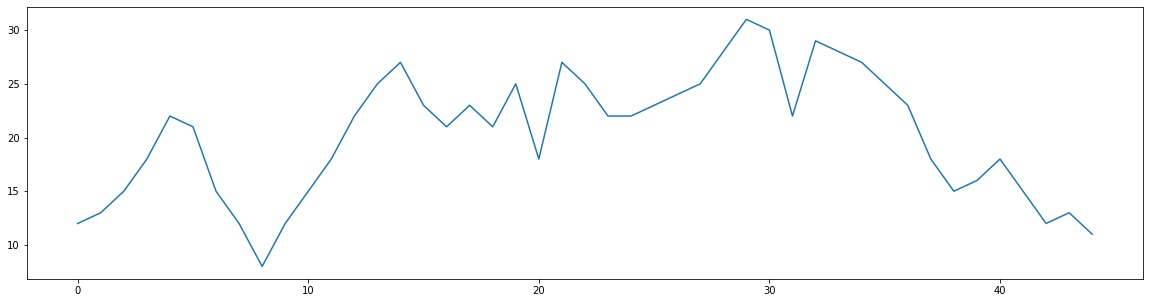

In [3]:
ts = [12, 13, 15, 18, 22, 21, 15, 12, 8,  12, 15, 18, 22, 25, 27, 23, 21, 23, 21, 25, 18, 27, 25, 22, 22, 23, 24, 25, 28, 31, 30, 22, 29, 28, 27, 25, 23, 18, 15, 16, 18, 15, 12, 13, 11]
ts = np.array(ts).astype(float)
plt.figure(figsize=[20,5])
plt.plot(ts);

In [4]:
tsGen = tkp.sequence.TimeseriesGenerator(ts, ts, length=6, batch_size=8)
model = tkm.Sequential()
model.add(tkl.Dense(12, activation='relu', input_dim=6))
model.add(tkl.Dense(8, activation='relu', input_dim=6))
model.add(tkl.Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(tsGen, steps_per_epoch=1, epochs=100, verbose=0)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12)                84        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 104       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 197
Trainable params: 197
Non-trainable params: 0
_________________________________________________________________


In [5]:
x_input = np.array([12, 13, 15, 18, 22, 21, 15, 12, 8,  12, 15, 18, 22, 25, 27, 23, 21, 23]).reshape((3, 6))
x_input
pred = model.predict(tsGen[0][0], verbose=0)

res = pd.DataFrame({'actual': tsGen[0][1], 'pred': np.round(pred.flatten(),1)})
res['diff'] = round(res['actual'] - res['pred'],1)
res

,actual,pred,diff
0,15.00,17.60,-2.60
1,12.00,20.40,-8.40
2,8.00,18.20,-10.20
3,12.00,12.70,-0.70
4,15.00,11.80,3.20
5,18.00,10.00,8.00
6,22.00,12.00,10.00
7,25.00,15.20,9.80


### Analize residuals 

Check if they are normally distributed (or at least symmetric)  
Use Q-Q plot to confirm  

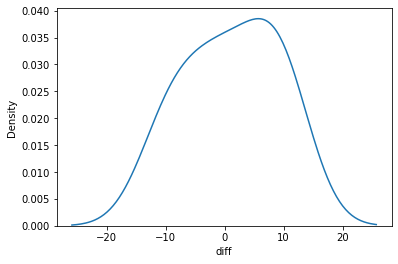

In [6]:
sns.kdeplot(res['diff']);

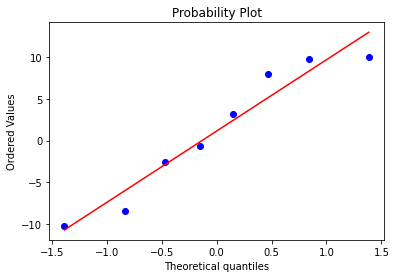

In [7]:
ss.probplot(res['diff'], plot=plt);

### AIC, BIC to assess generalization power
On different models, lower AIC, BIC is better

##### Calculate terms

In [8]:
n = res.shape[0] 
sse = get_sse(res.actual, res.pred)
p = get_params(model)

##### Akaike's information criterion (AIC) 

$\large n \log[\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 ] + 2p $

In [9]:
aic(sse, n, p)

426.2762258962746

##### Bayesian information criterion (BIC)

$\large n \log[\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2 ] + p \log(n) $

In [10]:
bic(sse, n, p)

441.9262096072022